In [2]:
import argparse
import sys
from pathlib import Path

import cv2

# import nrrd
import gc

import numpy as np

import os
import SimpleITK as sitk
from scipy.interpolate import RegularGridInterpolator

import pydicom as dicom

import matplotlib.pyplot as plt
from scipy.ndimage import zoom
from scipy import ndimage

import glob

# !pip install nibabel
import nibabel as nib


In [3]:

def interp3(x,y,z,img_org, xr,yr,zr):
    """resampling"""
    
    xi,yi,zi = np.meshgrid(xr, yr, zr, indexing='ij')
    min_val = np.min(img_org)

    interp = RegularGridInterpolator((x,y,z),img_org,bounds_error=False,fill_value=min_val)
    img = interp( (xi,yi,zi)).astype(np.float32)
    
    return img


def dicom2vol(path):
    """dicom folder to 3-D image"""
    image_shape = []
    path = str(path)
    dicom_files = glob.glob(os.path.join(path,'**/*.dcm'), recursive = True)
    if len(dicom_files) ==0:
        dicom_files = glob.glob(os.path.join(path,'**/*.IMA'), recursive = True)
    slices = [dicom.read_file(s, force=True) for s in dicom_files]
    slices = sorted(slices,key=lambda x:x.ImagePositionPatient[2])
    pixel_spacing = slices[0].PixelSpacing
    slice_thickness = np.abs(slices[0].SliceLocation-slices[-1].SliceLocation)/np.float32(len(slices)-1.0)
    
    tmp_shape = list(slices[0].pixel_array.shape)
    image_shape.append(len(slices))
    image_shape.append(tmp_shape[0])
    image_shape.append(tmp_shape[1])
    
    image_shape = np.array(image_shape).astype(np.int32)
    
    volume3d = np.zeros(image_shape)
    for i,s in enumerate(slices):
        array2d = s.pixel_array
        volume3d[i] = array2d*s.RescaleSlope + s.RescaleIntercept

    ## x,y,z -> z,y,x
    volume3d = np.moveaxis(volume3d,0,-1)
    volume3d = np.moveaxis(volume3d,0,1)
    
    image_res = [pixel_spacing[1], pixel_spacing[0], slice_thickness]

        
    return volume3d, image_res

def dicom2nifty(path_dicom):
    
    volume3d, image_res = dicom2vol(path_dicom)
    
    affine_matrix = np.eye(4)
    affine_matrix[0,0] = image_res[0]
    affine_matrix[1,1] = image_res[1]
    affine_matrix[2,2] = image_res[2]
    
    img = nib.Nifti1Image(volume3d[::-1,::-1,:], affine_matrix)
    
    nib.save(img,os.path.join(path_dicom + '_org.nii.gz'))
    
    return np.moveaxis(volume3d,0,1), image_res


def centroid3(img):
    nx, ny, nz = img.shape
    # print(nx,ny,nz)
    imgx = np.sum(np.sum(img, axis=1), axis=1)
    imgy = np.sum(np.sum(img, axis=2), axis=0)
    imgz = np.sum(np.sum(img, axis=0), axis=0)
    denom = np.sum(np.sum(np.sum(img, axis=0), axis=0), axis=0)
    cx = np.sum(np.linspace(0, nx-1, nx)*imgx)/denom
    cy = np.sum(np.linspace(0, ny-1, ny)*imgy)/denom
    cz = np.sum(np.linspace(0, nz-1, nz)*imgz)/denom
    
    return cx, cy, cz
   

In [4]:
vessel_ct = sitk.ReadImage('vessel_ct.nii.gz')
vessel_us = sitk.ReadImage('vessel_linear_scan_dense_25_us.nii')

In [5]:
print(vessel_ct.GetOrigin())
print(vessel_us.GetOrigin())

(0.0, 0.0, 0.0)
(0.0, 0.0, 0.0)


In [6]:
## resampling reference size and resolution

ref_dx, ref_dy, ref_dz = 1.0, 1.0, 1.0
ref_nx, ref_ny, ref_nz = 384, 384, 384

xr = (np.linspace(0, ref_nx-1, ref_nx) - (ref_nx-1)/2.0)*ref_dx
yr = (np.linspace(0, ref_ny-1, ref_ny) - (ref_ny-1)/2.0)*ref_dy
zr = (np.linspace(0, ref_nz-1, ref_nz) - (ref_nz-1)/2.0)*ref_dz

In [7]:
ct_shape = vessel_ct.GetSize()
ct_res = vessel_ct.GetSpacing()

us_shape = vessel_us.GetSize()
us_res = vessel_us.GetSpacing()

In [8]:
print(ct_shape)
print(ct_res)
print(us_shape)
print(us_res)

(512, 512, 256)
(0.699999988079071, 0.699999988079071, 0.699999988079071)
(50, 1080, 500)
(0.8059622049331665, 0.1875, 0.1875)


In [9]:

tmp_ct_img = (sitk.GetArrayFromImage(vessel_ct)).astype(np.float32)
tmp_ct_img = np.moveaxis(tmp_ct_img, 2, 0)
tmp_ct_img = np.moveaxis(tmp_ct_img, 2, 1)

tmp_us_img = (sitk.GetArrayFromImage(vessel_us)).astype(np.float32)
tmp_us_img = np.moveaxis(tmp_us_img, 2, 0)
tmp_us_img = np.moveaxis(tmp_us_img, 2, 1)


In [10]:
print(tmp_ct_img.shape)
print(tmp_us_img.shape)

(512, 512, 256)
(50, 1080, 500)


In [11]:
## resampling ct and ultrasound images

x = (np.linspace(0, ct_shape[0]-1, ct_shape[0]) - (ct_shape[0]-1)/2.0)*ct_res[0]
y = (np.linspace(0, ct_shape[1]-1, ct_shape[1]) - (ct_shape[1]-1)/2.0)*ct_res[1]
z = (np.linspace(0, ct_shape[2]-1, ct_shape[2]) - (ct_shape[2]-1)/2.0)*ct_res[2]
img_ct = interp3(x, y, z, tmp_ct_img, xr, yr, zr)
img_ct = np.moveaxis(img_ct, 1, 2)
img_ct = np.moveaxis(img_ct, 0, 2)

x = (np.linspace(0, us_shape[0]-1, us_shape[0]) - (us_shape[0]-1)/2.0)*us_res[0]
y = (np.linspace(0, us_shape[1]-1, us_shape[1]) - (us_shape[1]-1)/2.0)*us_res[1]
z = (np.linspace(0, us_shape[2]-1, us_shape[2]) - (us_shape[2]-1)/2.0)*us_res[2]
img_us = interp3(x, y, z, tmp_us_img, xr, yr, zr)
img_us = np.moveaxis(img_us, 1, 2)
img_us = np.moveaxis(img_us, 0, 2)

In [12]:
# set the fixed image: CT
fixed_image = sitk.GetImageFromArray(img_ct.astype(np.float32)) 
fixed_image.SetSpacing((ref_dx,ref_dy,ref_dz))
sitk.WriteImage(fixed_image,'vessel_ct_resample.nii.gz')

In [13]:
# set the moving image: ultrasound

# adjust to the same image shape and direction >> depending on the probe position: need to be fixed.
img_us_move = np.moveaxis(img_us, 0, 2)
img_us_move = np.moveaxis(img_us_move, 0, 1)
img_us_move = img_us_move[::-1,:,::-1]

moving_image = sitk.GetImageFromArray(img_us_move.astype(np.float32)) 
moving_image.SetSpacing((ref_dx,ref_dy,ref_dz))
sitk.WriteImage(moving_image,'vessel_us_resample.nii.gz')

In [14]:
# First, we calculate the centroid and move (=attach) ultrasound image to ct image

cx_us, cy_us, cz_us = np.round(centroid3(np.squeeze(img_us_move))).astype(np.int32)
cx_ct, cy_ct, cz_ct = np.round(centroid3(np.squeeze(img_ct))).astype(np.int32)
diff_x = cx_us-cx_ct
diff_y = cy_us-cy_ct
diff_z = cz_us-cz_ct
print("Coordinate difference:\t (diff_x, diff_y, diff_z) = (%d, %d, %d)"%(diff_x, diff_y, diff_z))
print("Resolution: \t\t (res_x, res_y, res_z) = (%.2f, %.2f, %.2f)"%(ref_dx,ref_dy,ref_dz))

Coordinate difference:	 (diff_x, diff_y, diff_z) = (-8, 24, 25)
Resolution: 		 (res_x, res_y, res_z) = (1.00, 1.00, 1.00)


In [15]:
# Usually vessel images are apart from each other. 
# Move the ultrasound image using centroid: now ultrasound and ct vessels are close, which is good for the rigid registration. 

img_us_move_centroid = interp3((xr-diff_x), (yr-diff_y), (zr-diff_z), img_us_move, xr, yr, zr)

In [16]:
moving_image = sitk.GetImageFromArray(img_us_move_centroid.astype(np.float32)) 
moving_image.SetSpacing((ref_dx,ref_dy,ref_dz))


In [17]:
## https://simpleitk.org/SPIE2019_COURSE/04_basic_registration.html

initial_transform = sitk.CenteredTransformInitializer(fixed_image, 
                                                      moving_image, 
                                                      sitk.Euler3DTransform(), 
                                                      sitk.CenteredTransformInitializerFilter.GEOMETRY)

In [18]:
num_iter = 2
for ii in range(num_iter):
    registration_method = sitk.ImageRegistrationMethod()
    registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=20)
    registration_method.SetMetricSamplingStrategy(registration_method.REGULAR )
    registration_method.SetMetricSamplingPercentage(0.2)    
    registration_method.SetInterpolator(sitk.sitkNearestNeighbor)
    registration_method.SetOptimizerAsGradientDescent(learningRate=1.0, numberOfIterations=30, convergenceMinimumValue=1e-7, convergenceWindowSize=10)
    registration_method.SetOptimizerScalesFromPhysicalShift()
    
    # Setup for the multi-resolution framework.            
    # registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
    # registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2,1,0])
    # registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()
    
    # Don't optimize in-place. We want to run this cell multiple times.
    registration_method.SetInitialTransform(initial_transform, inPlace=False)
    
    rigid_transform = registration_method.Execute(fixed_image, moving_image)

In [19]:
print(rigid_transform)

itk::simple::CompositeTransform
 CompositeTransform (0x15c67ccd0)
   RTTI typeinfo:   itk::CompositeTransform<double, 3u>
   Reference Count: 1
   Modified Time: 45307254
   Debug: Off
   Object Name: 
   Observers: 
     none
   Transforms in queue, from begin to end:
   >>>>>>>>>
   Euler3DTransform (0x17f7e4cf0)
     RTTI typeinfo:   itk::Euler3DTransform<double>
     Reference Count: 1
     Modified Time: 45307100
     Debug: Off
     Object Name: 
     Observers: 
       none
     Matrix: 
       0.999967 -0.0080982 0.000933316 
       0.00809943 0.999966 -0.00131599 
       -0.000922628 0.0013235 0.999999 
     Offset: [12.2465, -1.88895, -1.17481]
     Center: [191.5, 191.5, 191.5]
     Translation: [10.8681, -0.596365, -1.09829]
     Inverse: 
       0.999967 0.00809943 -0.000922628 
       -0.0080982 0.999966 0.0013235 
       0.000933316 -0.00131599 0.999999 
     Singular: 0
     Euler's angles: AngleX=0.0013235 AngleY=0.000922629 AngleZ=0.0080983
     m_ComputeZYX = 0
   En

In [20]:
moving_reg = sitk.Resample(moving_image, fixed_image, rigid_transform, sitk.sitkLinear, 0.0, moving_image.GetPixelID())
sitk.WriteImage(moving_reg,'vessel_reg.nii.gz')

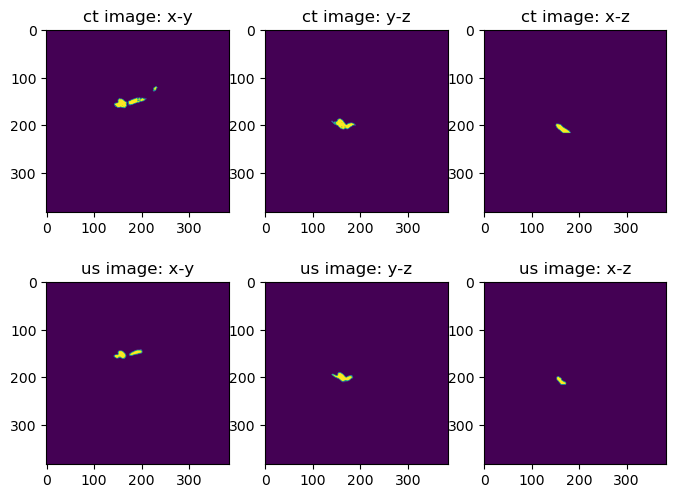

In [21]:
img_ct_final = (sitk.GetArrayFromImage(fixed_image)).astype(np.float32)
img_us_final = (sitk.GetArrayFromImage(moving_reg)).astype(np.float32)

cz_ct, cx_ct, cy_ct = np.round(centroid3(np.squeeze(img_ct_final))).astype(np.int32)

plt.figure(figsize=(8, 6))
plt.subplot(2, 3, 1)
plt.title('ct image: x-y')
plt.imshow(np.squeeze(img_ct_final[cz_ct]))
plt.subplot(2, 3, 2)
plt.title('ct image: y-z')
plt.imshow(np.squeeze(img_ct_final[:,cx_ct,:]))
plt.subplot(2, 3, 3)
plt.title('ct image: x-z')
plt.imshow(np.squeeze(img_ct_final[:,:,cy_ct]))
plt.subplot(2, 3, 4)
plt.title('us image: x-y')
plt.imshow(np.squeeze(img_us_final[cz_ct]))
plt.subplot(2, 3, 5)
plt.title('us image: y-z')
plt.imshow(np.squeeze(img_us_final[:,cx_ct,:]))
plt.subplot(2, 3, 6)
plt.title('us image: x-z')
plt.imshow(np.squeeze(img_us_final[:,:,cy_ct]))